In [2]:
! eups list -s lsst_distrib

   gdf42428520+759eb90f97 	current w_2023_07 setup


In [11]:
import pylab as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr.isrTask import IsrTask
from lsst.cp.pipe.cpCombine import CalibCombineTask
import pylab
import numpy

In [4]:
afwDisplay.setDefaultBackend('matplotlib') 
    
def display(exposure,title=None,frame=1):
    afw_display = afwDisplay.Display(frame)
#    afw_display.scale('asinh', 'zscale')
    afw_display.scale('asinh', 0, 1000)
    afw_display.mtv(exposure.getImage())
    plt.title(title)
#    plt.gca().axis('off')

In [5]:
repo_path = "/sdf/data/rubin/repo/ir2"

butler = Butler(repo_path)
collections = 'LSSTCam/raw/all,LSSTCam/calib,u/snyder18/spot_13237/gridfit_run1'.split(",")
butler = Butler(repo_path,collections=collections)
registry = butler.registry

In [6]:
!butler query-dimension-records /sdf/group/rubin/repo/ir2 detector | grep LSSTCam | grep R24_S11

   LSSTCam 112     R24_S11          S11     R24   SCIENCE


In [7]:
#collections = 'u/echarles/calib/bias/run_12781/20210326T180033Z'
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

1 DatasetType('camera', {instrument}, Camera, isCalibration=True)
3410239 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
2000 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
1 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
1 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
1 DatasetType('packages', {}, Packages)
0 DatasetType('cpCrosstalkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('crosstalkBackgroundZOffsets', {band, instrument, detector, physical_filter, exposure}, StructuredDataDict)
0 DatasetType('crosstalkBackgroundYTilts', {band, instrument, detector, physical_filter, exposure}, StructuredDataDict)
0 DatasetType('crosstalk

In [8]:
kwargs={
"datasetType": "postISRCCD",
"collections": collections,
"where":
"""
instrument='LSSTCam' and
exposure.science_program in ( '13237' ) and
detector=112
"""
}

datasetRefs = list(registry.queryDatasets(**kwargs))
print( f"You have {len(datasetRefs)} in this repository with the condition supplied {kwargs}")

You have 2000 in this repository with the condition supplied {'datasetType': 'postISRCCD', 'collections': ['LSSTCam/raw/all', 'LSSTCam/calib', 'u/snyder18/spot_13237/gridfit_run1'], 'where': "\ninstrument='LSSTCam' and\nexposure.science_program in ( '13237' ) and\ndetector=112\n"}


In [9]:
#!butler query-collections /sdf/group/rubin/repo/ir2

/tmp/ipykernel_9209/1870580850.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(numpy.arange(x-w+1,x+w+1,20).astype(int))
/tmp/ipykernel_9209/1870580850.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(numpy.arange(y-w+1,y+w+1,20).astype(int))


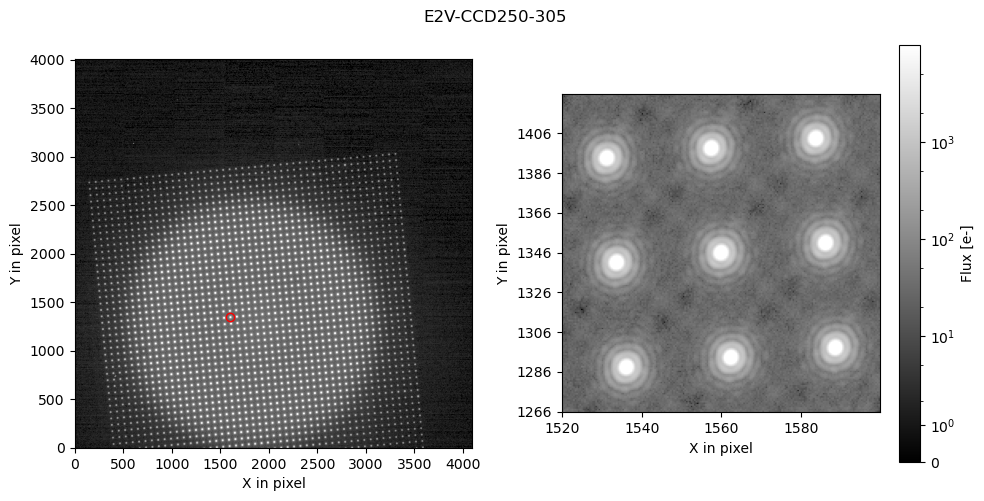

In [19]:
img = butler.get(datasetRefs[21])

cat = butler.get('gridSpotSrc',datasetRefs[21].dataId)
raw = butler.get('raw',datasetRefs[21].dataId)

cat
fig,axs = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
common={
    "vmin": 0,
    "vmax": 10000,
    "norm": "asinh"
}
axs[0].imshow(img.image.array,cmap="gray",origin="lower",**common)
x,y=cat.asAstropy()["base_SdssCentroid_x","base_SdssCentroid_y"][1001]
axs[0].plot(x+1,y+1,"o",color="red",markerfacecolor="none")

w=100
p=axs[1].imshow(img[x-w+1:x+w+1,y-w+1:y+w+1].image.array,cmap="gray",origin="lower",**common)
axs[1].set_xticklabels(numpy.arange(x-w+1,x+w+1,20).astype(int))
axs[1].set_yticklabels(numpy.arange(y-w+1,y+w+1,20).astype(int))

for ax in axs:
    ax.set_xlabel("X in pixel")
    ax.set_ylabel("Y in pixel")    

fig.colorbar(p,label="Flux [e-]")
fig.suptitle(raw.getMetadata()["LSST_NUM"])
fig.tight_layout()
plt.savefig("spotgrid_example.png")